# Определение возраста покупателей

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path = '/datasets/faces/'

## Исследовательский анализ данных

### Размер выборки

In [39]:
df = pd.read_csv(path + 'labels.csv')

df.shape

(7591, 2)

In [40]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [42]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [43]:
df['file_name'].duplicated().sum()

0

Выборка состоит из 7591 фотографии. Дубликаты и пропуски отсутствуют.

### Распределение возрастов

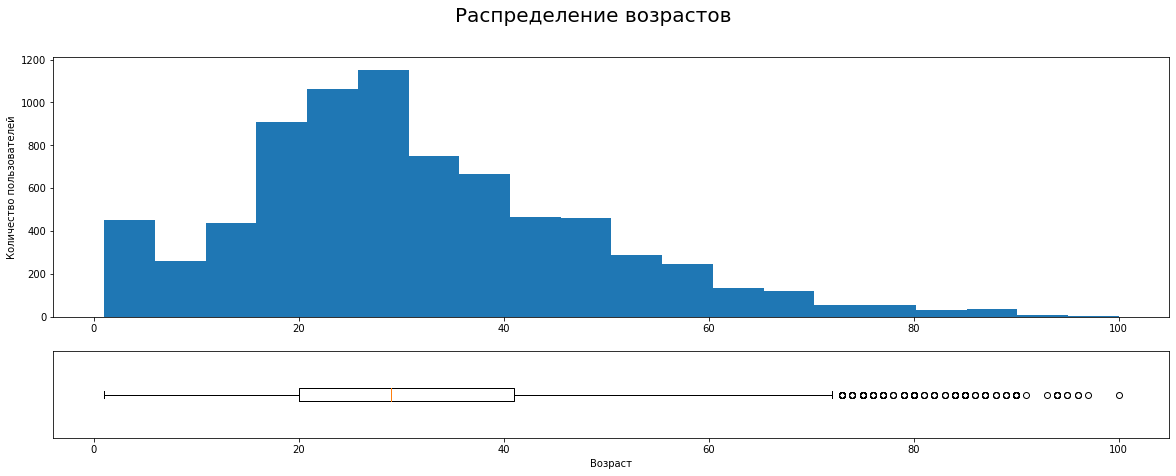

In [44]:
def plot_numeric(df, variable, title, xlabel, bins):
    '''Рисует графики распределения количественных переменных'''
    f, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(20, 7), gridspec_kw={'height_ratios': [3, 1]}
    )
    f.suptitle(title, fontsize=20)

    ax1.hist(df[variable], bins=bins)
    ax1.set_ylabel('Количество пользователей')

    ax2.boxplot(df[variable], vert=False)
    ax2.set_xlabel(xlabel)
    ax2.set_yticks([])

    plt.show()


plot_numeric(df, 'real_age', 'Распределение возрастов', 'Возраст', 20)

Большая часть фотографий - это люди 30 лет. Распределение скошено влево - в сторону меньшего возраста. Люди старше 70 уже выходят за 2 стандартных отклонения, и могут считаться выбросами. 

### Примеры фотографий

In [47]:
datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.25)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv'),
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=15,
    seed=12345,
)

Found 7591 validated image filenames.


In [49]:
batch = next(datagen_flow)[0]

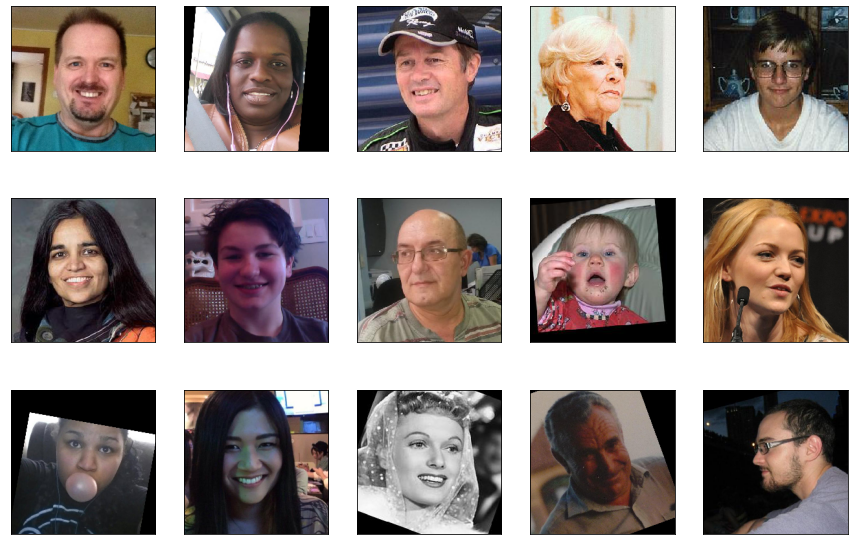

In [60]:
fig, ax = plt.subplots(3, 5)
fig.set_figheight(10)
fig.set_figwidth(15)

i = 0
row = 0
col = 0
while i < 14:
    while row <= 2:
        while col <= 4:
            ax[row, col].imshow(batch[i])
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])

            i += 1
            col += 1

        row += 1
        col = 0
plt.show()

Мы видим фотографии людей разного возраста. Часть фотографий плохого качества, другая часть содержит шум в виде неровных черных полей по бокам, еще у части фотографий есть искажения справа. Встречаются фотографии, на которых изображены не лица людей, а их тела в полный рост. 

Нам нужно обучить модель, которая учла бы все эти особенности.

#### EDA Промежуточный вывод
<ul>
    <li>Выборка состоит из 7591 фотографии. Дубликаты и пропуски отсутствуют.</li>
    <li>Возраста пользователей лежат в диапазоне от 1 до 100 лет</li>
    <li>Большая часть фотографий - это люди около 30 лет</li>
    <li>Распределение скошено влево - в сторону меньшего возраста</li>
    <li>Люди старше 70 уже выходят за 2 стандартных отклонения, и могут считаться выбросами</li>
    <li>Среди изображений встречаются следующие дефекты:
        <ol>
            <li>Низкое качество</li>
            <li>Шум в виде неровных черных полей по бокам</li>
            <li>Искажения справа</li>
            <li>Тела в полный рост, а не только лица</li>
        </ol>
    </li> 
</ul>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
import pandas as pd
import numpy as np
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='training',
        directory=path + 'final_files/',
        target_size=(224, 224),
        batch_size=16,
        seed=12345)
 
    return train_datagen_flow
 
def load_test(path):
    train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    test_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='validation',
        directory=path + 'final_files/',
        target_size=(224, 224),
        batch_size=16,
        seed=12345)
 
    return test_datagen_flow
 
def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
 
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  metrics=[MeanAbsoluteError()], 
                  loss='mse')
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/5
356/356 - 68s - loss: 193.1613 - mean_absolute_error: 10.1640 - val_loss: 642.0208 - val_mean_absolute_error: 20.2484

Epoch 2/5
356/356 - 38s - loss: 66.8793 - mean_absolute_error: 6.2279 - val_loss: 122.6896 - val_mean_absolute_error: 8.2738

Epoch 3/5
356/356 - 38s - loss: 38.3735 - mean_absolute_error: 4.7884 - val_loss: 117.7188 - val_mean_absolute_error: 8.3050

Epoch 4/5
356/356 - 38s - loss: 24.5147 - mean_absolute_error: 3.8102 - val_loss: 86.4662 - val_mean_absolute_error: 7.2918

Epoch 5/5
356/356 - 38s - loss: 16.2111 - mean_absolute_error: 3.1019 - val_loss: 70.2940 - val_mean_absolute_error: 6.3491

119/119 - 10s - loss: 70.2940 - mean_absolute_error: 6.3491
Test MAE: 6.3491

```

## Анализ обученной модели

Нам удалось создать модель, которая успешно справилась с задачей. Это архитектура **ResNet50** с одним выходным нейроном, который прогнозировал цифру возраста. Хорошую обучаемость модели обеспечил низкий *learning rate* оптимизатора *Adam* и небольшой размер батча. Скорость обучения удалось повысить, используя *MSE* в качестве функции потерь.